# NFL Concussions EDA (2012 to 2014)

Link to Data: https://www.kaggle.com/datasets/rishidamarla/concussions-in-the-nfl-20122014

### Necessary Imports

In [425]:
%matplotlib inline

from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize': (16, 8)})

### Read in and Manipulate Data

In [426]:
# Read in Data
df = pd.read_csv("NFL Concussion Injuries 2012-2014.csv")

# Convert Date Column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Data Cleaning for Play Time After Injury
df["Play Time After Injury"] = df["Play Time After Injury"].replace("Did not return from injury", 0)
df["Play Time After Injury"].fillna(0, inplace=True)
df['Play Time After Injury'] = df['Play Time After Injury'].str.replace(r'\D+', '', regex=True).fillna(0)
df['Play Time After Injury'] = df['Play Time After Injury'].astype(int)

# Data Cleaning for Average Playtime Before Injury
df["Average Playtime Before Injury"].fillna(0, inplace=True)
df['Average Playtime Before Injury'] = df['Average Playtime Before Injury'].str.replace(r'\D+', '', regex=True).fillna(0)
df['Average Playtime Before Injury'] = df['Average Playtime Before Injury'].astype(int)/100

df.head()

,ID,Player,Team,Game,Date,Opposing Team,Position,Pre-Season Injury?,Winning Team?,Week of Injury,Season,Weeks Injured,Games Missed,Unknown Injury?,Reported Injury Type,Total Snaps,Play Time After Injury,Average Playtime Before Injury
0,Aldrick Robinson - Washington Redskins vs. Tam...,Aldrick Robinson,Washington Redskins,Washington Redskins vs. Tampa Bay Buccaneers (...,2012-09-30,Tampa Bay Buccaneers,Wide Receiver,No,Yes,4,2012/2013,1,1.0,No,Head,0,14,37.0
1,D.J. Fluker - Tennessee Titans vs. San Diego C...,D.J. Fluker,San Diego Chargers,Tennessee Titans vs. San Diego Chargers (22/9/...,2013-09-22,Tennessee Titans,Offensive Tackle,No,No,3,2013/2014,1,1.0,No,Concussion,0,78,73.5
2,Marquise Goodwin - Houston Texans vs. Buffalo ...,Marquise Goodwin,Buffalo Bills,Houston Texans vs. Buffalo Bills (28/9/2014),2014-09-28,Houston Texans,Wide Receiver,No,No,4,2014/2015,1,1.0,No,Concussion,0,25,17.5
3,Bryan Stork - New England Patriots vs. Buffalo...,Bryan Stork,New England Patriots,New England Patriots vs. Buffalo Bills (12/10/...,2014-12-10,Buffalo Bills,Center,No,Yes,6,2014/2015,1,1.0,No,Head,0,82,41.5
4,Lorenzo Booker - Chicago Bears vs. Indianapoli...,Lorenzo Booker,Chicago Bears,Chicago Bears vs. Indianapolis Colts (9/9/2012),2012-09-09,Indianapolis Colts,Running Back,Yes,Yes,1,2012/2013,0,NaN,No,Head,0,0,0.0


In [427]:
df.describe()

,Week of Injury,Weeks Injured,Games Missed,Total Snaps,Play Time After Injury,Average Playtime Before Injury
count,392.000000,392.000000,361.000000,392.000000,392.000000,392.000000
mean,8.548469,0.920918,0.925208,32.038265,38.505102,41.256097
std,5.004111,0.270211,1.742429,22.228552,28.853630,24.314764
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,14.000000,12.000000,22.500000
50%,9.000000,1.000000,0.000000,29.000000,38.000000,43.315000
75%,13.000000,1.000000,1.000000,48.000000,64.000000,62.185000
max,19.000000,1.000000,14.000000,93.000000,99.000000,84.670000


# Data Visualizations

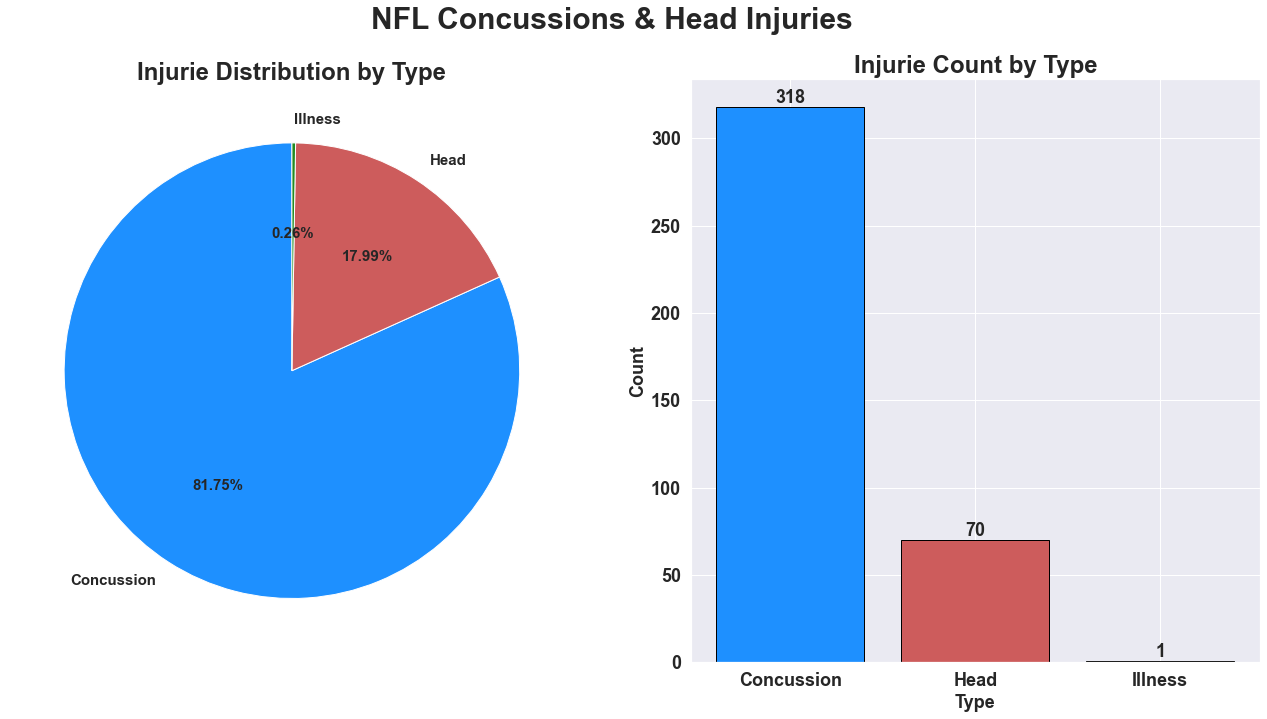

In [428]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

colors = ['dodgerblue', 'indianred', 'forestgreen']

types = df.groupby('Reported Injury Type').size().reset_index().rename(columns = {0:'counts'})

ax[0].pie(types.counts,
        autopct='%1.2f%%',
        labels = types['Reported Injury Type'], 
        startangle=90,
        rotatelabels=False,
        colors=colors,
        textprops={'fontsize': 15, 'fontweight':'bold'})
ax[0].set_title('Injurie Distribution by Type', fontsize=24, fontweight='bold')

ax[1].bar(types['Reported Injury Type'],
          types.counts,
          color=colors,
          edgecolor='black'
         )
ax[1].bar_label(ax[1].containers[0], fontsize=18, fontweight='bold')
ax[1].set_title('Injurie Count by Type', fontsize=24, fontweight='bold')
plt.yticks(size=18, fontweight='bold')
ax[1].set_xticks([r for r in range(len(types['Reported Injury Type']))], types['Reported Injury Type'], fontsize=18, fontweight='bold')
ax[1].set_xlabel('Type', fontsize=18, fontweight='bold')
ax[1].set_ylabel('Count', fontsize=18, fontweight='bold')

plt.suptitle('NFL Concussions & Head Injuries', fontsize=30, fontweight='bold')

plt.show()

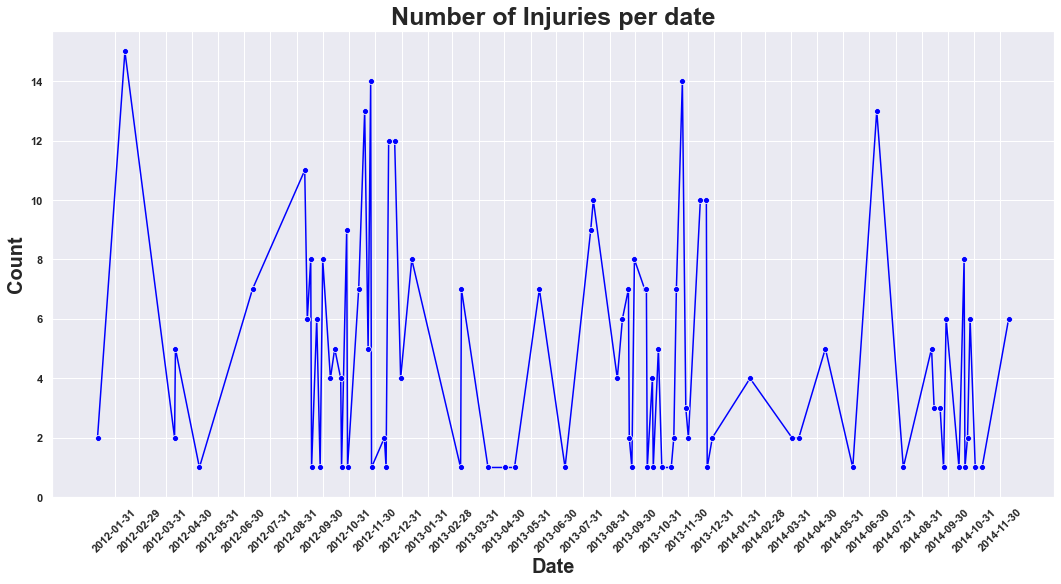

In [429]:
sns.set(rc={'figure.figsize': (16, 8)})

injuries_by_date = df.groupby(["Date"], sort=True)["ID"].count()

sns.lineplot(x=injuries_by_date.index, y=injuries_by_date.values, color='blue', marker='o')

plt.xticks(pd.date_range(injuries_by_date.index[0], injuries_by_date.index[-1], freq="m"), rotation=45)

plt.xlabel("Date", fontsize=20, fontweight='bold')
plt.ylabel("Count", fontsize=20, fontweight='bold')
plt.title("Number of Injuries per date", fontsize=25, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.ylim(0,None)


plt.show()

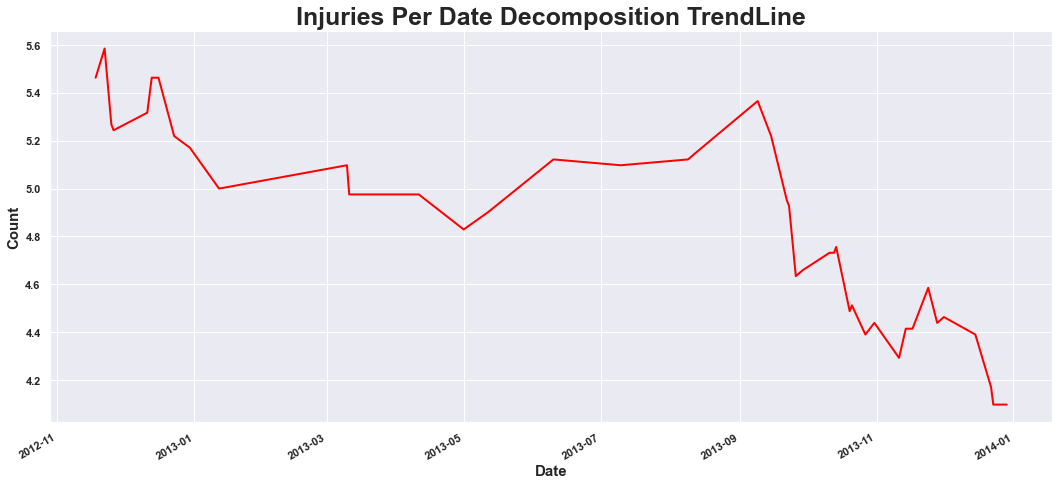

In [430]:
sns.set(rc={'figure.figsize': (16, 8)})

decomp = sm.tsa.seasonal_decompose(injuries_by_date, period=int(len(injuries_by_date)/2))
ax = decomp.trend.plot(color='red', linewidth=2)

ax.set_xlabel('Date')
ax.set_title('Injuries Per Date Decomposition TrendLine', fontsize=25, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel("Date", fontsize=15, fontweight='bold')
plt.ylabel("Count", fontsize=15, fontweight='bold')
plt.show()

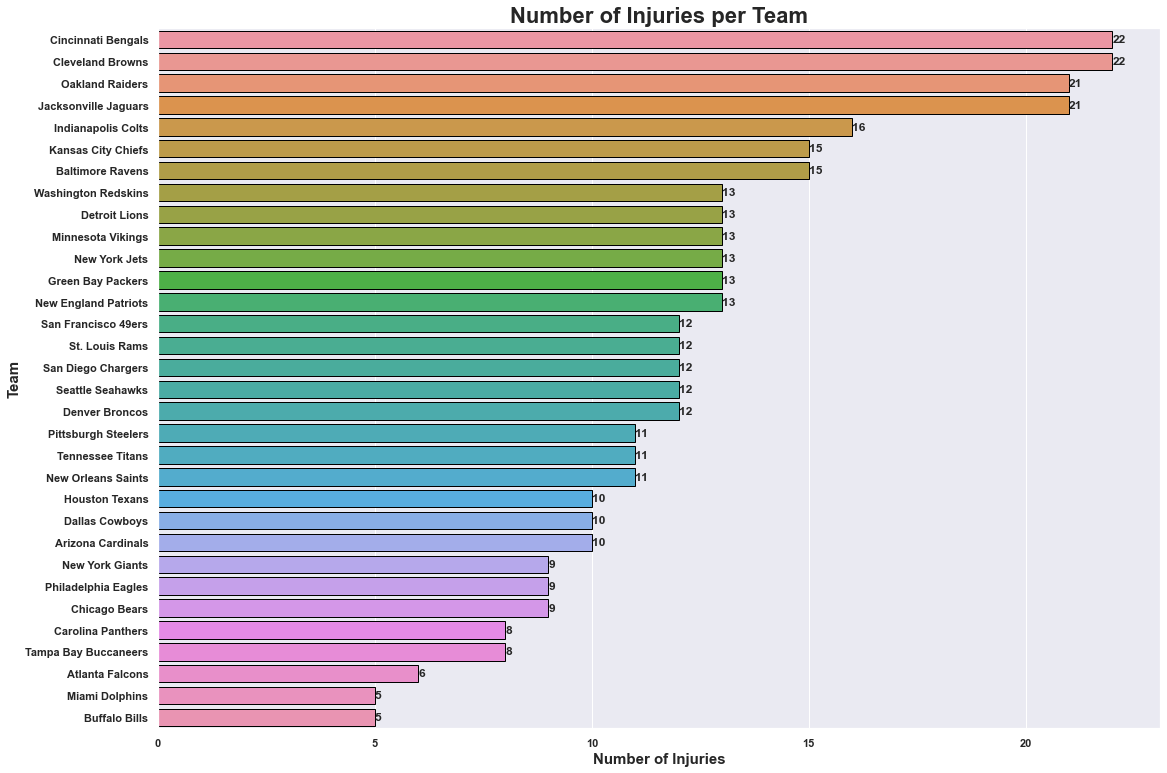

In [431]:
sns.set(rc={'figure.figsize': (16, 12)})
plot = sns.countplot(y="Team", data=df, order = df['Team'].value_counts().index, edgecolor='black')
plt.bar_label(plot.containers[0], fontweight='bold')
plt.xlabel("Number of Injuries", fontsize=15, fontweight='bold')
plt.ylabel("Team", fontsize=15, fontweight='bold')
plt.title("Number of Injuries per Team", fontsize=22, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

In [432]:
pd.pivot_table(df, index=["Team"], columns="Reported Injury Type", aggfunc="count") \
                ["Game"].sort_values("Concussion", ascending=False).fillna(0)

Reported Injury Type,Concussion,Head,Illness
Team,,,
Oakland Raiders,21.0,0.0,0.0
Jacksonville Jaguars,20.0,1.0,0.0
Cincinnati Bengals,17.0,4.0,0.0
Minnesota Vikings,13.0,0.0,0.0
New York Jets,13.0,0.0,0.0
Green Bay Packers,13.0,0.0,0.0
San Diego Chargers,12.0,0.0,0.0
San Francisco 49ers,12.0,0.0,0.0
Cleveland Browns,12.0,10.0,0.0


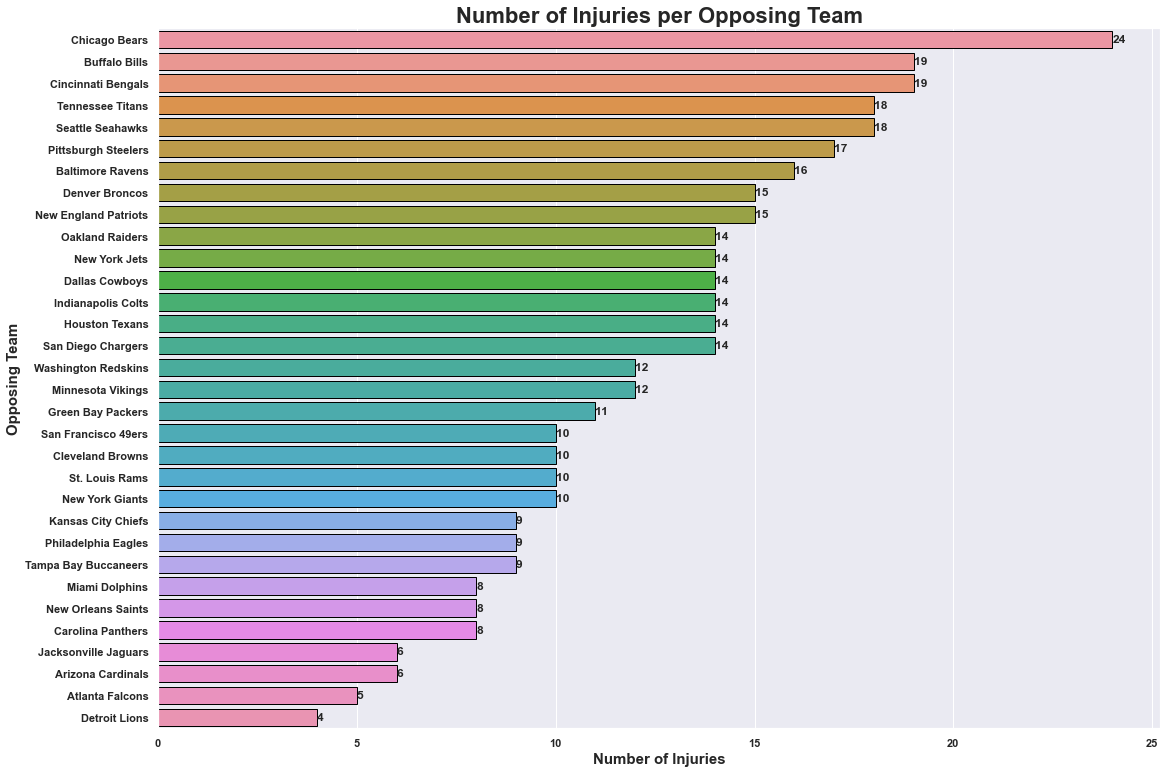

In [433]:
sns.set(rc={'figure.figsize': (16, 12)})
plot = sns.countplot(y="Opposing Team", data=df, order = df['Opposing Team'].value_counts().index, edgecolor='black')
plt.bar_label(plot.containers[0], fontweight='bold')
plt.xlabel("Number of Injuries", fontsize=15, fontweight='bold')
plt.ylabel("Opposing Team", fontsize=15, fontweight='bold')
plt.title("Number of Injuries per Opposing Team", fontsize=22, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

In [434]:
pd.pivot_table(df, index=["Opposing Team"], columns="Reported Injury Type", aggfunc="count") \
                ["Game"].sort_values("Concussion", ascending=False).fillna(0)

Reported Injury Type,Concussion,Head,Illness
Opposing Team,,,
Chicago Bears,19.0,5.0,0.0
Tennessee Titans,17.0,0.0,0.0
Seattle Seahawks,15.0,2.0,0.0
Baltimore Ravens,14.0,2.0,0.0
Buffalo Bills,14.0,5.0,0.0
Cincinnati Bengals,14.0,5.0,0.0
New York Jets,14.0,0.0,0.0
Indianapolis Colts,13.0,1.0,0.0
Houston Texans,13.0,1.0,0.0


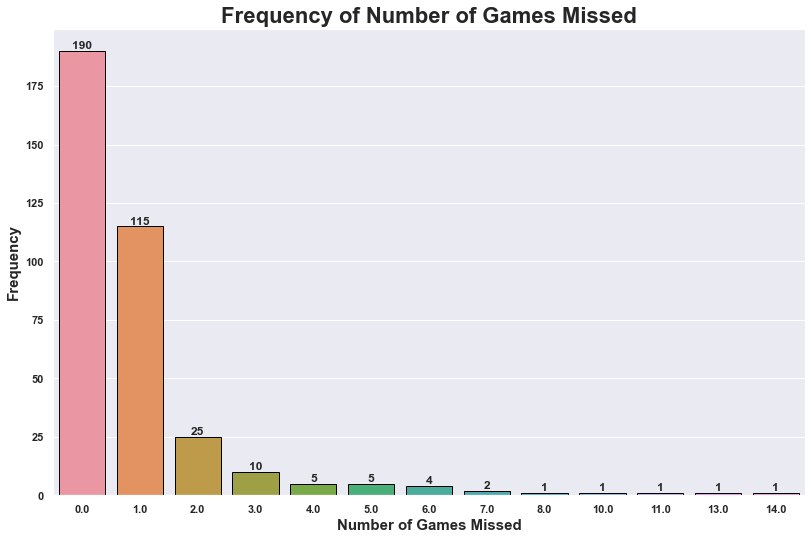

In [435]:
sns.set(rc={'figure.figsize': (12, 8)})
plot = sns.countplot(x="Games Missed", data=df, edgecolor='black')
plt.bar_label(plot.containers[0], fontweight='bold')
plt.xlabel("Number of Games Missed", fontsize=15, fontweight='bold')
plt.ylabel("Frequency", fontsize=15, fontweight='bold')
plt.title("Frequency of Number of Games Missed", fontsize=22, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

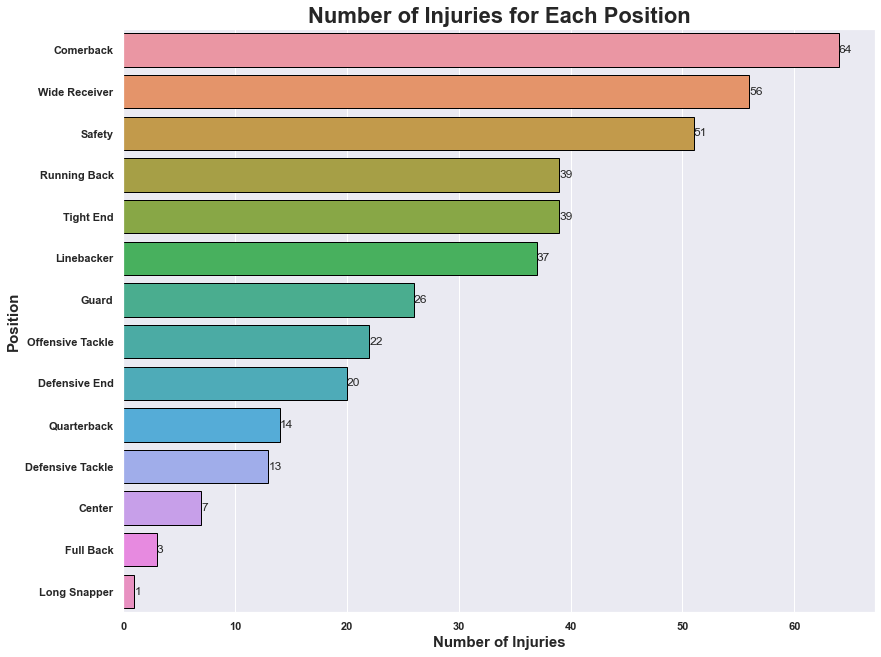

In [436]:
sns.set(rc={'figure.figsize': (12, 10)})
inj_by_pos = df["Position"].value_counts()
plot = sns.barplot(y=inj_by_pos.index, x=inj_by_pos.values, edgecolor='black')
plt.bar_label(plot.containers[0])

plt.xlabel("Number of Injuries", fontsize=15, fontweight='bold')
plt.ylabel("Position", fontsize=15, fontweight='bold')
plt.title("Number of Injuries for Each Position", fontsize=22, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()

In [437]:
pd.pivot_table(df, index=["Position"], columns="Reported Injury Type", aggfunc="count") \
                ["Game"].sort_values("Concussion", ascending=False).fillna(0)

Reported Injury Type,Concussion,Head,Illness
Position,,,
Comerback,53.0,11.0,0.0
Safety,46.0,5.0,0.0
Wide Receiver,43.0,13.0,0.0
Linebacker,32.0,3.0,0.0
Running Back,32.0,7.0,0.0
Tight End,29.0,9.0,0.0
Guard,21.0,4.0,1.0
Defensive End,17.0,3.0,0.0
Offensive Tackle,15.0,7.0,0.0


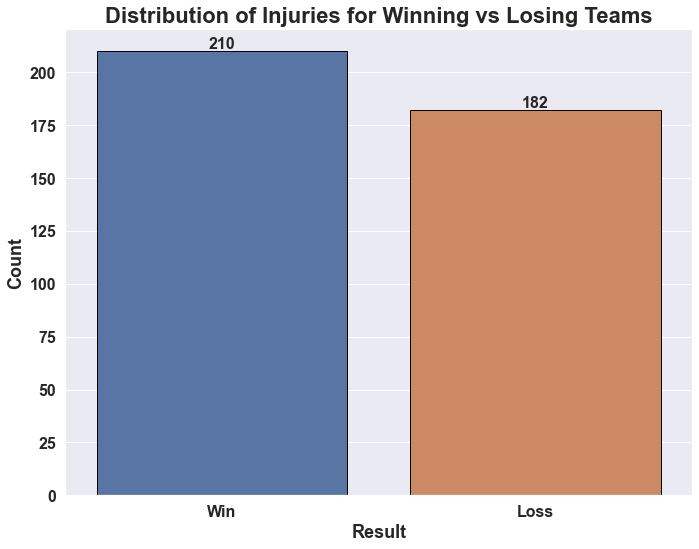

In [438]:
sns.set(rc={'figure.figsize': (10,8)})

labels = ['Win', 'Loss']

inj_by_win = df["Winning Team?"].value_counts()
plot = sns.barplot(x=inj_by_win.index, y=inj_by_win.values, edgecolor='black')
plt.bar_label(plot.containers[0], fontsize=16, fontweight='bold')

plt.xticks([r for r in range(len(labels))], labels, fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel("Result", fontsize=18, fontweight='bold')
plt.ylabel("Count", fontsize=18, fontweight='bold')
plt.title("Distribution of Injuries for Winning vs Losing Teams", fontsize=22, fontweight='bold')

plt.show()

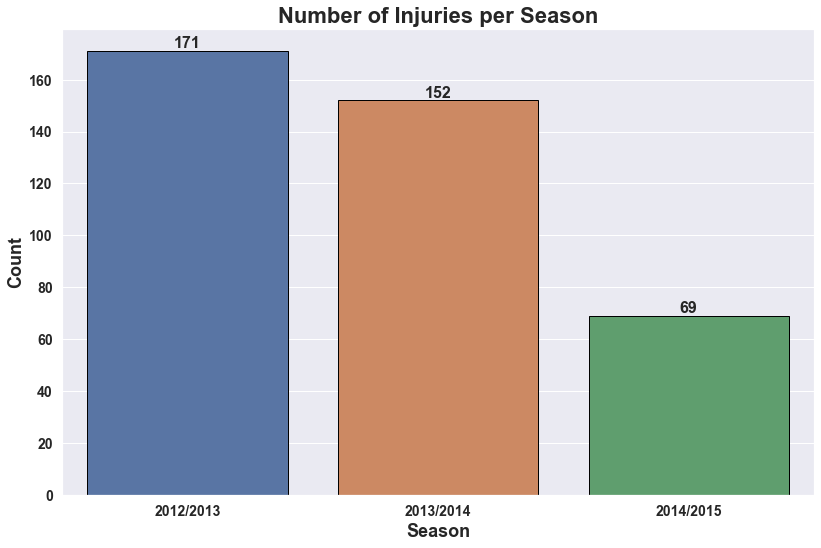

In [439]:
sns.set(rc={'figure.figsize': (12,8)})

by_season = df["Season"].value_counts()
plot = sns.barplot(x=by_season.index, y=by_season.values, edgecolor='black')
plt.bar_label(plot.containers[0], fontsize=16, fontweight='bold')

plt.xlabel("Season", fontsize=18, fontweight='bold')
plt.ylabel("Count", fontsize=18, fontweight='bold')
plt.title("Number of Injuries per Season", fontsize=22, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.show()

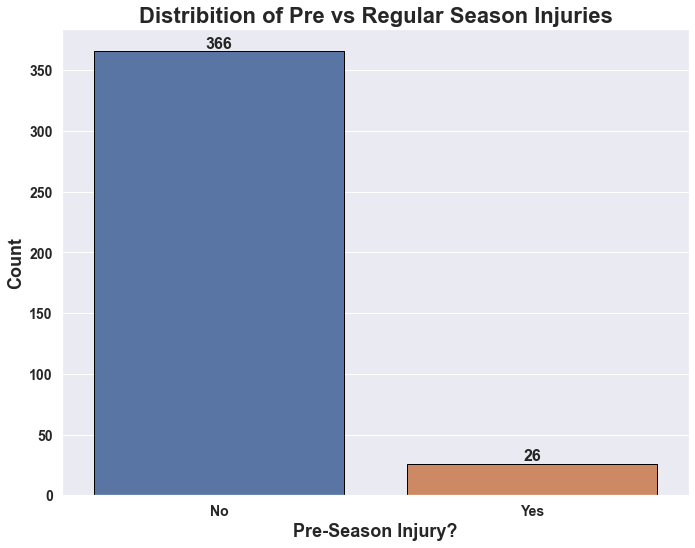

In [440]:
sns.set(rc={'figure.figsize': (10,8)})

pre_season = df["Pre-Season Injury?"].value_counts()
plot = sns.barplot(x=pre_season.index, y=pre_season.values, edgecolor='black')
plt.bar_label(plot.containers[0], fontsize=16, fontweight='bold')

plt.xlabel("Pre-Season Injury?", fontsize=18, fontweight='bold')
plt.ylabel("Count", fontsize=18, fontweight='bold')
plt.title("Distribition of Pre vs Regular Season Injuries", fontsize=22, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.show()

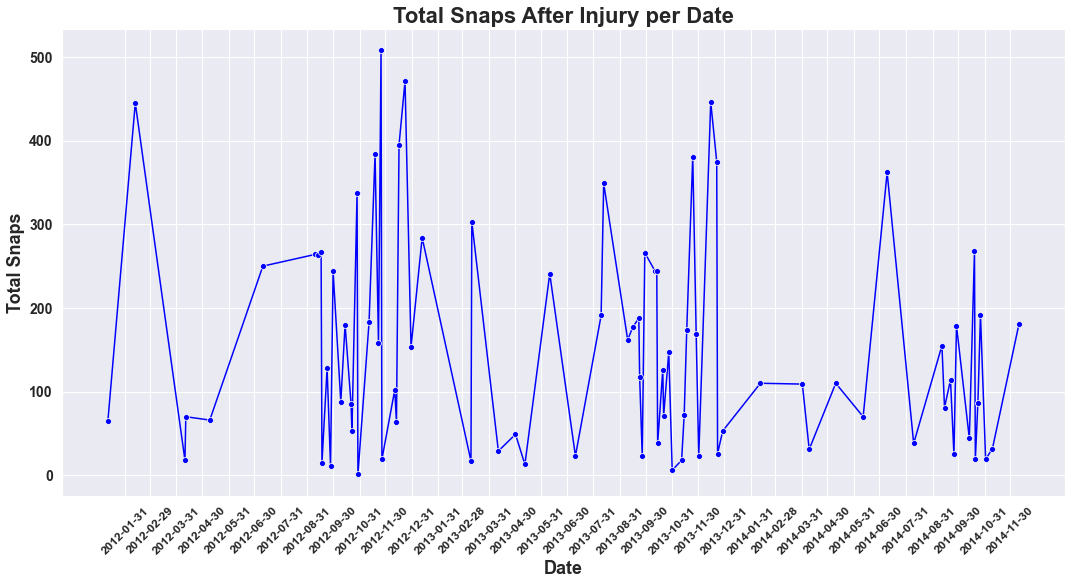

In [441]:
sns.set(rc={'figure.figsize': (16,8)})

snaps = df.groupby("Date")["Total Snaps"].sum()
sns.lineplot(x=snaps.index, y=snaps.values, color='blue', marker='o')
plt.xticks(pd.date_range(snaps.index[0], snaps.index[-1], freq="M"), rotation=45)

plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("Total Snaps", fontsize=18, fontweight='bold')
plt.title("Total Snaps After Injury per Date", fontsize=22, fontweight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.show()

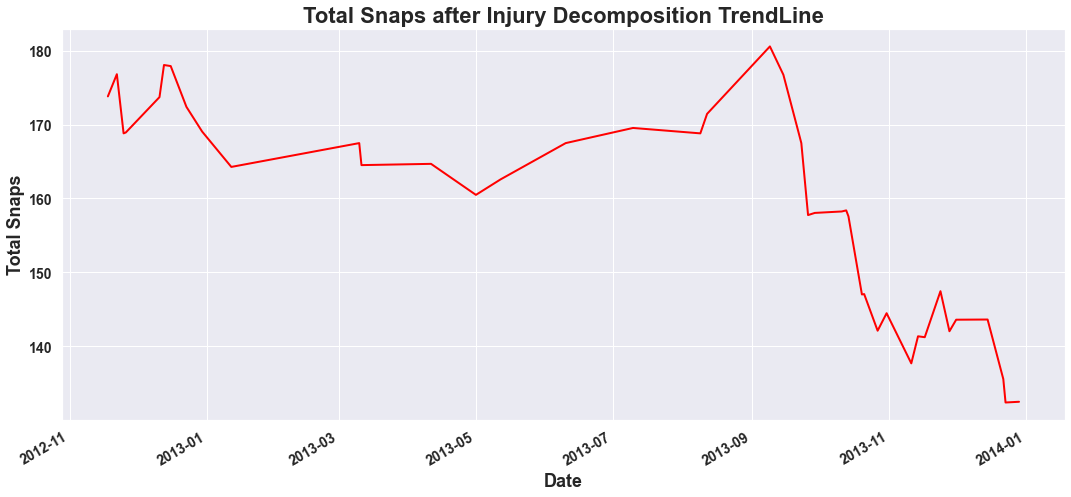

In [442]:
sns.set(rc={'figure.figsize': (16,8)})

snaps_decomp = sm.tsa.seasonal_decompose(snaps, period=int(len(snaps)/2))

ax = snaps_decomp.trend.plot(color='red', linewidth=2)

ax.set_xlabel('Date')
ax.set_title('Total Snaps after Injury Decomposition TrendLine', fontsize=22, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("Total Snaps", fontsize=18, fontweight='bold')

plt.show()

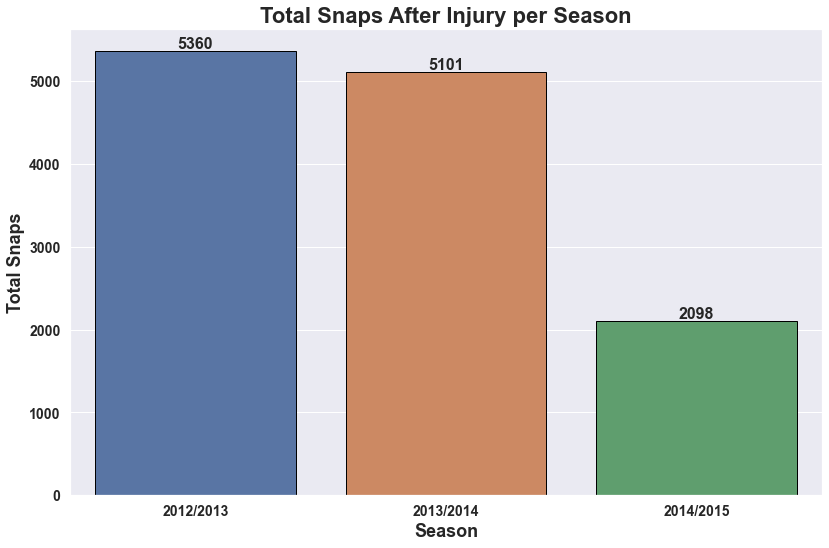

In [443]:
sns.set(rc={'figure.figsize': (12,8)})

by_sea_snaps = df.groupby("Season")["Total Snaps"].sum()
plot = sns.barplot(x=by_sea_snaps.index, y=by_sea_snaps.values, edgecolor='black')
plt.bar_label(plot.containers[0], fontsize=16, fontweight='bold')

plt.xlabel("Season", fontsize=18, fontweight='bold')
plt.ylabel("Total Snaps", fontsize=18, fontweight='bold')
plt.title("Total Snaps After Injury per Season", fontsize=22, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.show()

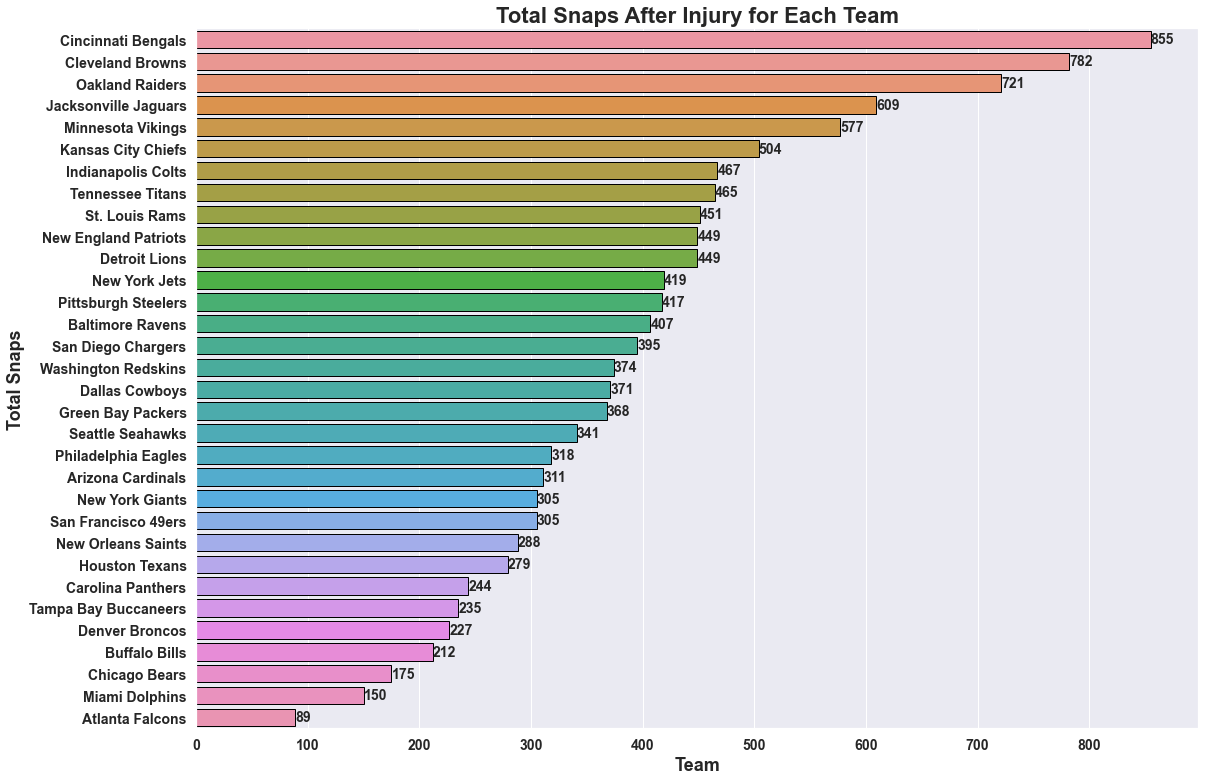

In [444]:
sns.set(rc={'figure.figsize': (16, 12)})

snaps = df.groupby(["Team"])["Total Snaps"].sum().sort_values(ascending=False)

plot=sns.barplot(y=snaps.index, x=snaps.values, edgecolor='black')
plt.bar_label(plot.containers[0], fontsize=14, fontweight='bold')
plt.xlabel("Team", fontsize=18, fontweight='bold')
plt.ylabel("Total Snaps", fontsize=18, fontweight='bold')
plt.title("Total Snaps After Injury for Each Team", fontsize=22, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.show()

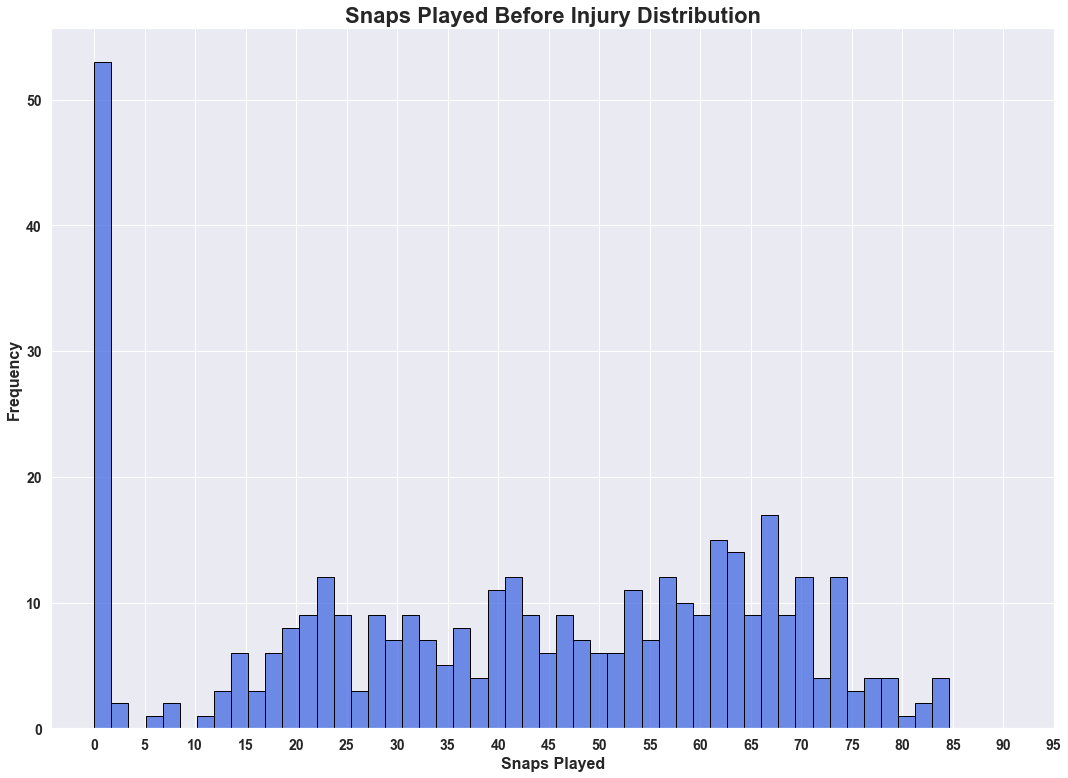

In [445]:
sns.histplot(x='Average Playtime Before Injury', color='royalblue', data=df, bins=50,edgecolor='black')
plt.xticks(np.arange(0, 100, 5))

plt.xlabel("Snaps Played", fontsize=16, fontweight='bold')
plt.ylabel("Frequency", fontsize=16, fontweight='bold')
plt.title("Snaps Played Before Injury Distribution", fontsize=22, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.show()

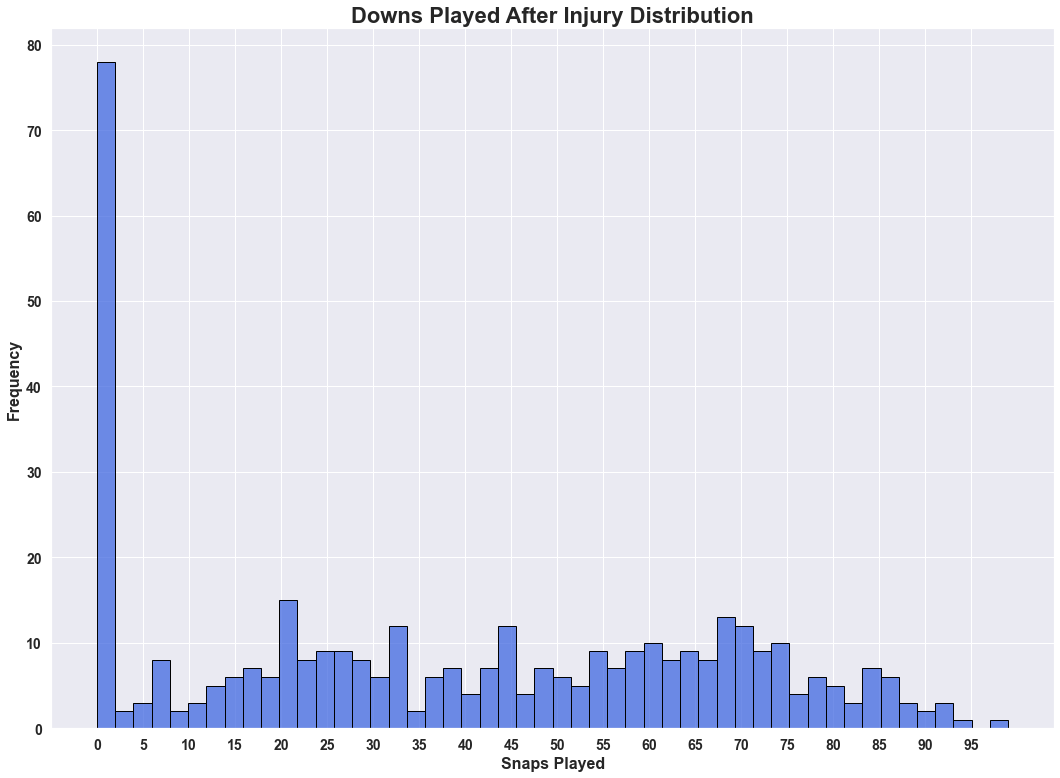

In [446]:
sns.histplot(x='Play Time After Injury',color='royalblue', bins=50,data=df, edgecolor='black')
plt.xticks(np.arange(0, 100, 5))

plt.xlabel("Snaps Played", fontsize=16, fontweight='bold')
plt.ylabel("Frequency", fontsize=16, fontweight='bold')
plt.title("Downs Played After Injury Distribution", fontsize=22, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()

# Predictive Modeling

In [447]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              392 non-null    object        
 1   Player                          392 non-null    object        
 2   Team                            392 non-null    object        
 3   Game                            392 non-null    object        
 4   Date                            392 non-null    datetime64[ns]
 5   Opposing Team                   392 non-null    object        
 6   Position                        392 non-null    object        
 7   Pre-Season Injury?              392 non-null    object        
 8   Winning Team?                   392 non-null    object        
 9   Week of Injury                  392 non-null    int64         
 10  Season                          392 non-null    object        
 11  Weeks 

In [448]:
categories = ["Team",
              "Opposing Team",
              "Position",
              "Pre-Season Injury?",
              "Winning Team?",
              "Week of Injury",
              "Season",
              "Unknown Injury?",
              "Reported Injury Type"]

In [449]:
y = df["Games Missed"]
y.fillna(0, inplace=True)

In [450]:
df_ml = df.drop(["Games Missed", "ID", "Player", "Date", "Game"], axis=1)
df_ml = pd.get_dummies(df_ml, drop_first=True, columns=categories)
x = df_ml
df_ml.head()

,Weeks Injured,Total Snaps,Play Time After Injury,Average Playtime Before Injury,Team_Atlanta Falcons,Team_Baltimore Ravens,Team_Buffalo Bills,Team_Carolina Panthers,Team_Chicago Bears,Team_Cincinnati Bengals,...,Week of Injury_15,Week of Injury_16,Week of Injury_17,Week of Injury_18,Week of Injury_19,Season_2013/2014,Season_2014/2015,Unknown Injury?_Yes,Reported Injury Type_Head,Reported Injury Type_Illness
0,1,0,14,37.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,78,73.5,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,25,17.5,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,82,41.5,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [451]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [452]:
KFold_Score = pd.DataFrame()
classifiers = ['LinearRegression', 'RandomForestRegressor','GradientBoostingRegressor', 'AdaBoostRegressor']
models = [LinearRegression(),
          RandomForestRegressor(n_estimators=200, random_state=0),
          GradientBoostingRegressor(random_state=0),
          AdaBoostRegressor(random_state=0)]

In [453]:
j = 0
for i in models:
    model = i
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    KFold_Score[classifiers[j]] = -(cross_val_score(model, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=cv))
    j = j+1

In [454]:
mean = pd.DataFrame(KFold_Score.mean(), index= classifiers)
KFold_Score = pd.concat([KFold_Score,mean.T])
KFold_Score.index=['Fold 1','Fold 2','Fold 3','Fold 4', 'Fold 5', 'Mean']
KFold_Score.T.sort_values(by=['Mean'], ascending = True)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean
RandomForestRegressor,0.880909,0.873545,0.822909,1.124636,0.954815,0.931363
GradientBoostingRegressor,0.902105,0.921593,0.975944,1.057020,1.062337,0.983800
AdaBoostRegressor,1.373720,1.143086,1.021589,1.459913,1.357133,1.271088
LinearRegression,1.338020,1.526353,1.400358,1.565802,1.579002,1.481907


#### Random Forest Regressor Model has lowest mean absolute error - use this model to predict # games missed

In [455]:
model = RandomForestRegressor(n_estimators=200, random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

In [456]:
feature_importance = pd.DataFrame(data=model.feature_importances_, index=X_train.columns)
feature_importance.rename(columns={0: "Factors"}, inplace=True)
feature_importance.head(15)

,Factors
Weeks Injured,0.010159
Total Snaps,0.110424
Play Time After Injury,0.133740
Average Playtime Before Injury,0.062317
Team_Atlanta Falcons,0.000450
Team_Baltimore Ravens,0.000504
Team_Buffalo Bills,0.000409
Team_Carolina Panthers,0.003203
Team_Chicago Bears,0.000023
Team_Cincinnati Bengals,0.001775


In [457]:
feature_importance = feature_importance["Factors"].nlargest(15)

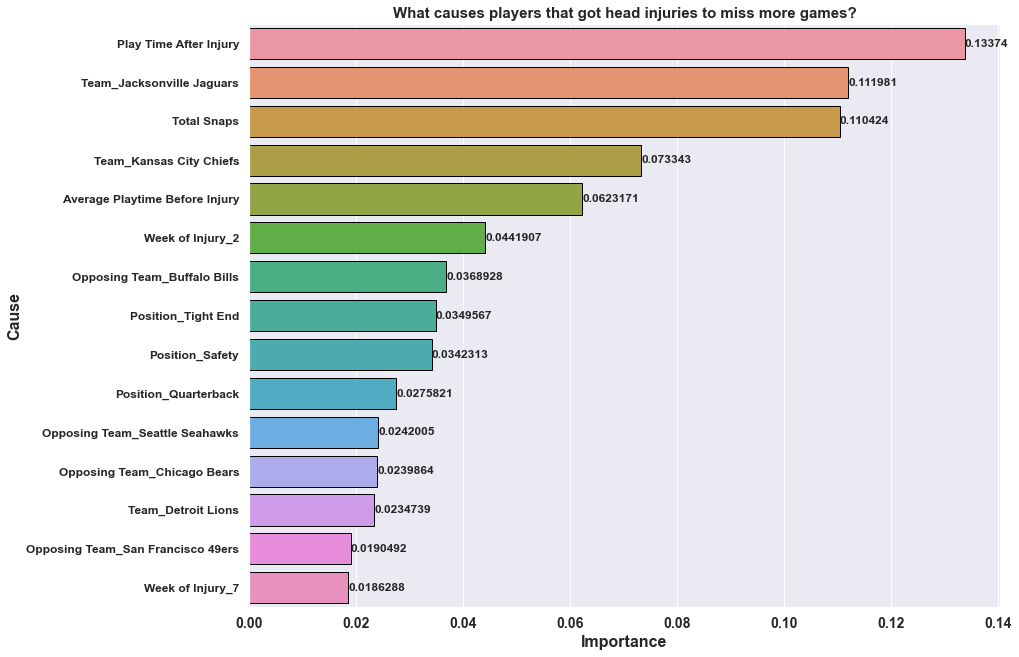

In [458]:
sns.set(rc={'figure.figsize': (12,10)})

plot=sns.barplot(y=feature_importance.index, x=feature_importance.values, edgecolor='black')
plt.bar_label(plot.containers[0], fontweight='bold')
plt.xlabel("Importance", fontsize=16, fontweight='bold')
plt.ylabel("Cause", fontsize=16, fontweight='bold')
plt.title("What causes players that got head injuries to miss more games?", fontsize=15, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()